# Read and preprocess data

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df = pd.read_csv('wdbc.data', header=None)
features = ['_mean','_std_err','_worst']
col = ['id','diagnosis','radius','texture','perimeter','area','smoothness','compactness',
       'concavity', 'concave_points', 'symmetry', 'fractal_dim']
res = ['id', 'diagnosis']

for i in range(2,len(col)):
    for f in features:
        res.append(col[i]+f)
df.columns = res
df.diagnosis.replace(['M','B'], [1,0], inplace=True) # Malignant = 1, Benign = 0
value = df.isnull().values.any() 
# false, therefore I don't need to take care of missing data
# neverthless I would, just for practice
imp = SimpleImputer(missing_values=np.nan, strategy='mean') 
# should use it in pipeline later

<AxesSubplot:>

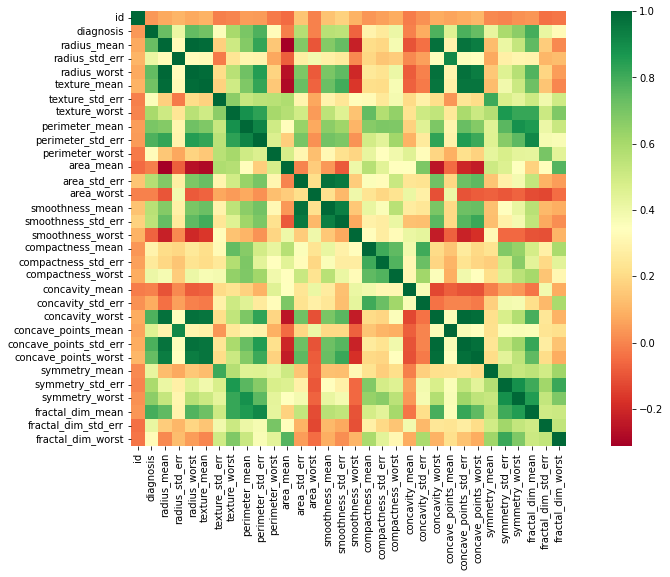

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt 

plt.figure(figsize = (16,8))
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

- compactness - zwartość
- concavity - wklęsłość
- fractal dimension - In mathematics, more specifically in fractal geometry, a fractal dimension is a ratio providing a statistical index of complexity comparing how detail in a pattern (strictly speaking, a fractal pattern) changes with the scale at which it is measured. (wiki)

# KNeighbors prediction

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
steps = [('imputation', imp),
        ('KNN', knn)]
pipeline = Pipeline(steps)

X = df.drop(['id','diagnosis'],axis=1)
y = df.diagnosis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test) # great score


0.9415204678362573

# Linear regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R^2: {}".format(np.sqrt(reg.score(X_test, y_test))))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root MSE: {}".format(rmse)) # good result we can use linear regression

# Cross validation
cv_results = []
for k in range(2, 22):
    cv_results.append(np.mean(cross_val_score(reg, X, y, cv=k)))
k = 1
print("Best CV score ({}-folds): {}".format(cv_results.index(max(cv_results))+2, max(cv_results)))
print("Average CV score: {}".format(np.mean(cv_results)))

R^2: 0.8512813416011156
Root MSE: 0.25392455905411604
Best CV score (7-folds): 0.7053292779610948
Average CV score: 0.6794799452117631


# Lasso regression
We want to find the most important feature

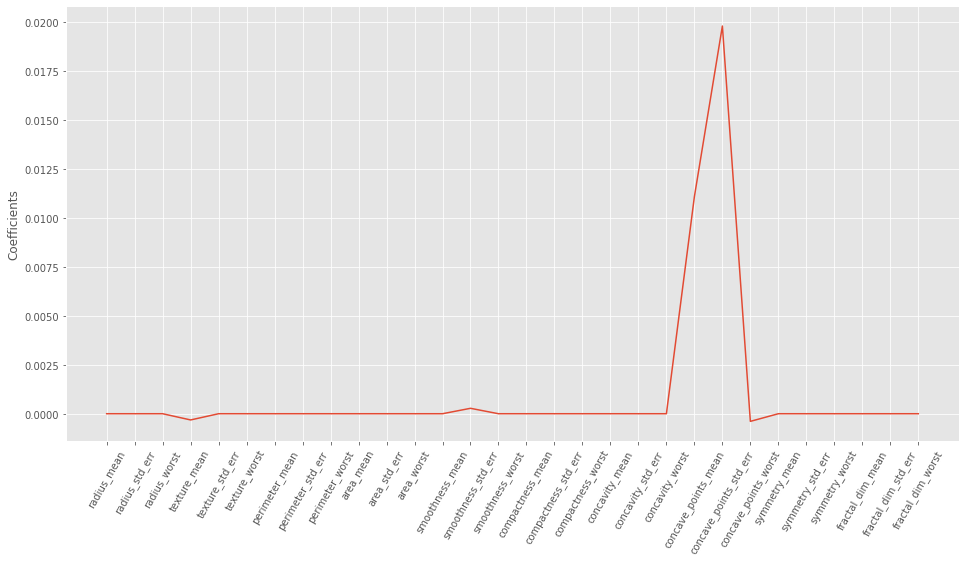

In [5]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X,y).coef_
plt.style.use('ggplot')
plt.figure(figsize = (16,8))
_ = plt.plot(range(len(X.columns)), lasso_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=60)
_ = plt.ylabel("Coefficients")
plt.show() # it looks like the most significant feature is mean of concave points

# Diagnosis plot

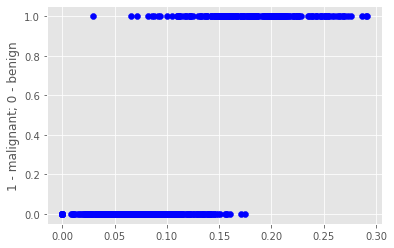

In [16]:
Xi = X.fractal_dim_mean
plt.scatter(Xi, y, color='b')
plt.ylabel('1 - malignant; 0 - benign')
plt.show()

# Confusion Matrix

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=5)
steps = [('imputation', imp),
        ('KNN', knn)]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred),'\n\n')
print(classification_report(y_test, y_pred))

[[103   4]
 [  6  58]] 


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       107
           1       0.94      0.91      0.92        64

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171

